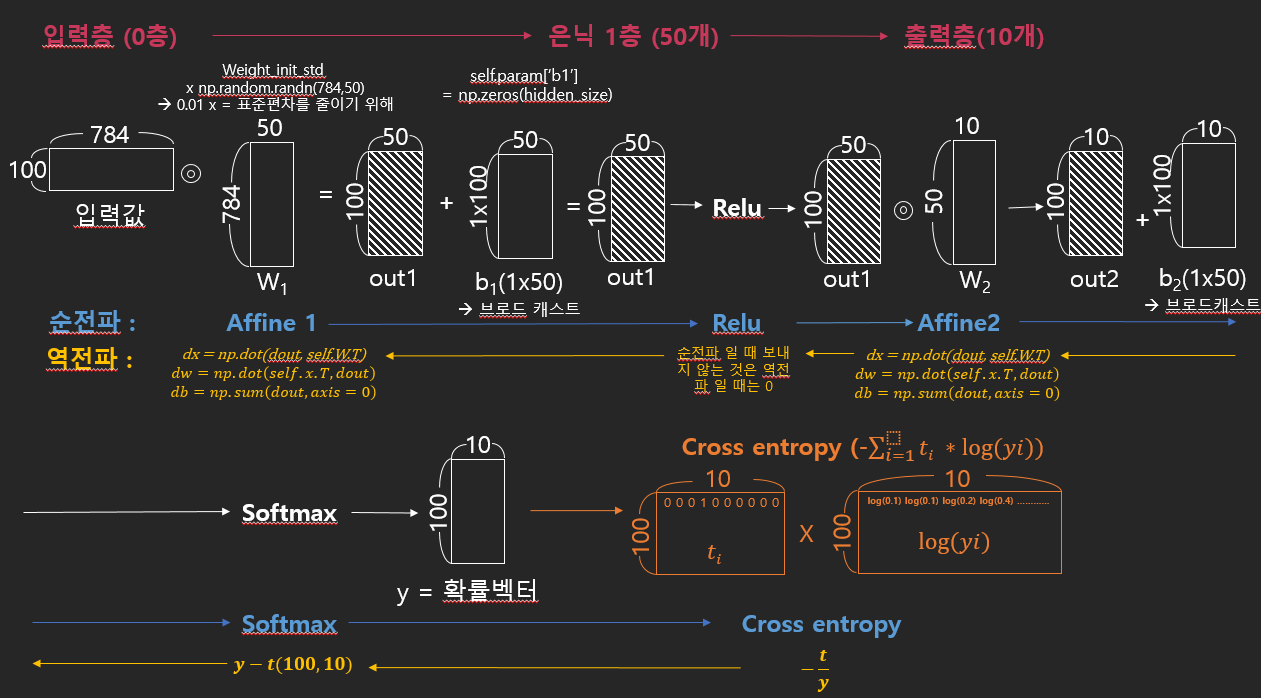

## ■ 칠판에 나온 오차 역전파를 이용한 2층 신경망 전체 코드

__순전파 :__ Affine1 --> Relu --> Affine2 --> Lastlayer  
__역전파 :__ Lastlayer --> Affine2 --> Relu --> Affine1

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

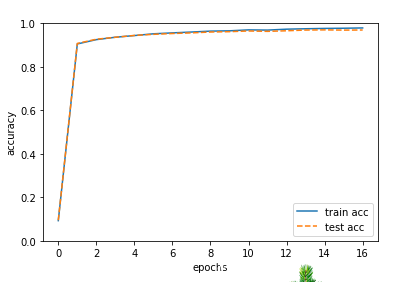

## 문제57. 위의 2층 신경망을 3층 신경망으로 변경하여 수행하시오!

입력층 --> 은닉1층 --> 은닉2층 --> 출력층  
( 입력층: 784, 은닉1층: 50, 은닉2층: 100, 출력층: 10)  

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:
    # 가중치(w)와 바이어스(b) 생성 및 초기값 생성 및 계층 생성하는 부분
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서를 중요하게 여기는 딕셔너리를 생성
        # 책 175 페이지의 Affine 계층을 참고하면서 아래 코드를 본다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu() # 책 166 페이지를 참고한다.
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu() # 책 166 페이지를 참고한다.
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss() # 책 179 페이지를 참고한다.
        
    # Affine1 --> Relu --> Affine2 로 순전파하는 함수
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 순전파하는 predict 함수에 입력값을 넣어서 확률을 출력하고
    # 소프트 맥스 함수와 오차함수에 y(확률)값과 t(정답)을 입력하여
    # 비용(loss)를 출력하는 함수
    # 즉 loss를 실행하면 순전파가 돔.

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 순전파의 정확도를 출력하는 함수
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # 수치미분하는 함수라서 여기코드에서는 작동하지 않음.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads
    
    
    def gradient(self, x, t):
        # forward 순전파를 먼저 실행한다.
        self.loss(x, t)
        # backward 역전파를 실행한다.
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values()) # reverse 하기 쉽도록 list로 변환
        layers.reverse() # Affine2 --> Relu --> Affine1이 된다.

        for layer in layers: # 역전파 하는 코드
            dout = layer.backward(dout)

        # 결과 저장
        grads = {} # 기울기를 구해서 grads 딕셔너리에 저장.
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 여기까지는 TwoLayerNet 클래스를 생성하는 부분이고 이 클래스를 사용해서
# 학습을 하는 부분은 지금부터이다. (p.186 ~ p.187)

# 저자가 만들어온 필기체 데이터(60000장)을 신경망에 넣기 쉽도록 구현한 
# load_mnist 함수를 실행한다.
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# get_data()도 이미 되어있는 상태
# 저자가 이미 default값으로  flatten = True로 설정하였음.
# (훈련데이터, 훈련 데이터 라벨) , (테스트데이터, 테스트데이터 라벨)
# nomalize = True 로 하여 입력 데이터를 정규화 시켰다.
# 입력값 데이터의 픽셀 하나의 값이 0~255 사이의 숫자인데 이 숫자를 min/max 정규화를 수행함.
# one_hot_label = True 는 정답을 [0 1 0 0 0 0 0 0 0 0] 이렇게 one hot encoding 함

# TwoLayerNet 클래스를 network으로 객체화 시킨다.
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2 = 100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.( 현재 반복횟수 = 10000회)
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

# 그래프를 그리기 위해서 필요한 데이터를 저장하기 위해 리스트 3개를 선언.
train_loss_list = [] # 훈련 데이터의 비용이 append 된다.
train_acc_list = [] # 훈련 데이터의 정확도가 append 된다.
test_acc_list = [] # 테스트 데이터의 정확도가 append 된다.

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
# 60000/ 100 = 600 즉, 600과 1중에 큰 값을 출력해라.

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) 
    # 60000개 중에 100개씩 뽑아서(복원추출) & 10000번 for 루프문
    # train_size = 60000, batch_size = 100
    x_batch = x_train[batch_mask] # 순련데이터 100개 복원추출
    t_batch = t_train[batch_mask] # 훈련데이터 정답 100개 복원추출

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # p.183 페이지 참고
    # grad에 W1, b1, W2, b2 4가지 기울기가 담긴다.
    
    # 매개변수 갱신( 가중치 최적화 수행)
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost(오차함수값) 이/가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 문제58.(점심시간 문제)   
## 위의 3층 신경망의 활성화 함수를 relu에서 sigmoid함수로 변경해서 수행하시오!

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:
    # 가중치(w)와 바이어스(b) 생성 및 초기값 생성 및 계층 생성하는 부분
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서를 중요하게 여기는 딕셔너리를 생성
        # 책 175 페이지의 Affine 계층을 참고하면서 아래 코드를 본다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss() # 책 179 페이지를 참고한다.
        
    # Affine1 --> Relu --> Affine2 로 순전파하는 함수
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 순전파하는 predict 함수에 입력값을 넣어서 확률을 출력하고
    # 소프트 맥스 함수와 오차함수에 y(확률)값과 t(정답)을 입력하여
    # 비용(loss)를 출력하는 함수
    # 즉 loss를 실행하면 순전파가 돔.

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 순전파의 정확도를 출력하는 함수
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # 수치미분하는 함수라서 여기코드에서는 작동하지 않음.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads
    
    
    def gradient(self, x, t):
        # forward 순전파를 먼저 실행한다.
        self.loss(x, t)
        # backward 역전파를 실행한다.
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values()) # reverse 하기 쉽도록 list로 변환
        layers.reverse() # Affine2 --> Relu --> Affine1이 된다.

        for layer in layers: # 역전파 하는 코드
            dout = layer.backward(dout)

        # 결과 저장
        grads = {} # 기울기를 구해서 grads 딕셔너리에 저장.
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 여기까지는 TwoLayerNet 클래스를 생성하는 부분이고 이 클래스를 사용해서
# 학습을 하는 부분은 지금부터이다. (p.186 ~ p.187)

# 저자가 만들어온 필기체 데이터(60000장)을 신경망에 넣기 쉽도록 구현한 
# load_mnist 함수를 실행한다.
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# (훈련데이터, 훈련 데이터 라벨) , (테스트데이터, 테스트데이터 라벨)
# nomalize = True 로 하여 입력 데이터를 정규화 시켰다.
# 입력값 데이터의 픽셀 하나의 값이 0~255 사이의 숫자인데 이 숫자를 min/max 정규화를 수행함.
# one_hot_label = True 는 정답을 [0 1 0 0 0 0 0 0 0 0] 이렇게 one hot encoding 함

# TwoLayerNet 클래스를 network으로 객체화 시킨다.
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2 = 100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

# 그래프를 그리기 위해서 필요한 데이터를 저장하기 위해 리스트 3개를 선언.
train_loss_list = [] # 훈련 데이터의 비용이 append 된다.
train_acc_list = [] # 훈련 데이터의 정확도가 append 된다.
test_acc_list = [] # 테스트 데이터의 정확도가 append 된다.

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
# 60000/ 100 = 600 즉, 600과 1중에 큰 값을 출력해라.

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) 
    # 60000개 중에 100개씩 뽑아서(복원추출) 10000번 for 루프문
    # train_size = 60000, batch_size = 100
    x_batch = x_train[batch_mask] # 순련데이터 100개 복원추출
    t_batch = t_train[batch_mask] # 훈련데이터 정답 100개 복원추출

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # p.183 페이지 참고
    # grad에 W1, b1, W2, b2 4가지 기울기가 담긴다.
    
    # 매개변수 갱신( 가중치 최적화 수행)
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost(오차함수값) 이/가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### " 다시 relu 함수로 원복시키시오 "

## 문제59. 러닝레이트 (학습률)을 0.1에서 0.01로 했을때의 수행 결과를 출력하시오!

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:
    # 가중치(w)와 바이어스(b) 생성 및 초기값 생성 및 계층 생성하는 부분
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서를 중요하게 여기는 딕셔너리를 생성
        # 책 175 페이지의 Affine 계층을 참고하면서 아래 코드를 본다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu() # 책 166 페이지를 참고한다.
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu() # 책 166 페이지를 참고한다.
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss() # 책 179 페이지를 참고한다.
        
    # Affine1 --> Relu --> Affine2 로 순전파하는 함수
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 순전파하는 predict 함수에 입력값을 넣어서 확률을 출력하고
    # 소프트 맥스 함수와 오차함수에 y(확률)값과 t(정답)을 입력하여
    # 비용(loss)를 출력하는 함수
    # 즉 loss를 실행하면 순전파가 돔.

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 순전파의 정확도를 출력하는 함수
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # 수치미분하는 함수라서 여기코드에서는 작동하지 않음.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads
    
    
    def gradient(self, x, t):
        # forward 순전파를 먼저 실행한다.
        self.loss(x, t)
        # backward 역전파를 실행한다.
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values()) # reverse 하기 쉽도록 list로 변환
        layers.reverse() # Affine2 --> Relu --> Affine1이 된다.

        for layer in layers: # 역전파 하는 코드
            dout = layer.backward(dout)

        # 결과 저장
        grads = {} # 기울기를 구해서 grads 딕셔너리에 저장.
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 여기까지는 TwoLayerNet 클래스를 생성하는 부분이고 이 클래스를 사용해서
# 학습을 하는 부분은 지금부터이다. (p.186 ~ p.187)

# 저자가 만들어온 필기체 데이터(60000장)을 신경망에 넣기 쉽도록 구현한 
# load_mnist 함수를 실행한다.
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# (훈련데이터, 훈련 데이터 라벨) , (테스트데이터, 테스트데이터 라벨)
# nomalize = True 로 하여 입력 데이터를 정규화 시켰다.
# 입력값 데이터의 픽셀 하나의 값이 0~255 사이의 숫자인데 이 숫자를 min/max 정규화를 수행함.
# one_hot_label = True 는 정답을 [0 1 0 0 0 0 0 0 0 0] 이렇게 one hot encoding 함

# TwoLayerNet 클래스를 network으로 객체화 시킨다.
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2 = 100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.01

# 그래프를 그리기 위해서 필요한 데이터를 저장하기 위해 리스트 3개를 선언.
train_loss_list = [] # 훈련 데이터의 비용이 append 된다.
train_acc_list = [] # 훈련 데이터의 정확도가 append 된다.
test_acc_list = [] # 테스트 데이터의 정확도가 append 된다.

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
# 60000/ 100 = 600 즉, 600과 1중에 큰 값을 출력해라.

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) 
    # 60000개 중에 100개씩 뽑아서(복원추출) 10000번 for 루프문
    # train_size = 60000, batch_size = 100
    x_batch = x_train[batch_mask] # 순련데이터 100개 복원추출
    t_batch = t_train[batch_mask] # 훈련데이터 정답 100개 복원추출

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # p.183 페이지 참고
    # grad에 W1, b1, W2, b2 4가지 기울기가 담긴다.
    
    # 매개변수 갱신( 가중치 최적화 수행)
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost(오차함수값) 이/가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 문제60. 다시 러닝 레이트를 0.1로 원복시키고 3층 신경망으로 최적화된 가중치와 바이어스를 pickle 파일로 내리시오.

In [ ]:
with open ("d:\\weight_bias.pkl", "wb") as f:
    pickle.dump(network.parmas,f)

In [ ]:
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
import pickle

class TwoLayerNet:
    # 가중치(w)와 바이어스(b) 생성 및 초기값 생성 및 계층 생성하는 부분
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서를 중요하게 여기는 딕셔너리를 생성
        # 책 175 페이지의 Affine 계층을 참고하면서 아래 코드를 본다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss() # 책 179 페이지를 참고한다.
        
    # Affine1 --> Relu --> Affine2 로 순전파하는 함수
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 순전파하는 predict 함수에 입력값을 넣어서 확률을 출력하고
    # 소프트 맥스 함수와 오차함수에 y(확률)값과 t(정답)을 입력하여
    # 비용(loss)를 출력하는 함수
    # 즉 loss를 실행하면 순전파가 돔.

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 순전파의 정확도를 출력하는 함수
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # 수치미분하는 함수라서 여기코드에서는 작동하지 않음.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads
    
    
    def gradient(self, x, t):
        # forward 순전파를 먼저 실행한다.
        self.loss(x, t)
        # backward 역전파를 실행한다.
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values()) # reverse 하기 쉽도록 list로 변환
        layers.reverse() # Affine2 --> Relu --> Affine1이 된다.

        for layer in layers: # 역전파 하는 코드
            dout = layer.backward(dout)

        # 결과 저장
        grads = {} # 기울기를 구해서 grads 딕셔너리에 저장.
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 여기까지는 TwoLayerNet 클래스를 생성하는 부분이고 이 클래스를 사용해서
# 학습을 하는 부분은 지금부터이다. (p.186 ~ p.187)

# 저자가 만들어온 필기체 데이터(60000장)을 신경망에 넣기 쉽도록 구현한 
# load_mnist 함수를 실행한다.
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# (훈련데이터, 훈련 데이터 라벨) , (테스트데이터, 테스트데이터 라벨)
# nomalize = True 로 하여 입력 데이터를 정규화 시켰다.
# 입력값 데이터의 픽셀 하나의 값이 0~255 사이의 숫자인데 이 숫자를 min/max 정규화를 수행함.
# one_hot_label = True 는 정답을 [0 1 0 0 0 0 0 0 0 0] 이렇게 one hot encoding 함

# TwoLayerNet 클래스를 network으로 객체화 시킨다.
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2 = 100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

# 그래프를 그리기 위해서 필요한 데이터를 저장하기 위해 리스트 3개를 선언.
train_loss_list = [] # 훈련 데이터의 비용이 append 된다.
train_acc_list = [] # 훈련 데이터의 정확도가 append 된다.
test_acc_list = [] # 테스트 데이터의 정확도가 append 된다.

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
# 60000/ 100 = 600 즉, 600과 1중에 큰 값을 출력해라.

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) 
    # 60000개 중에 100개씩 뽑아서(복원추출) 10000번 for 루프문
    # train_size = 60000, batch_size = 100
    x_batch = x_train[batch_mask] # 순련데이터 100개 복원추출
    t_batch = t_train[batch_mask] # 훈련데이터 정답 100개 복원추출

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # p.183 페이지 참고
    # grad에 W1, b1, W2, b2 4가지 기울기가 담긴다.
    
    # 매개변수 갱신( 가중치 최적화 수행)
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost(오차함수값) 이/가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

with open ("d:\\weight_bias.pkl", "wb") as f:
    pickle.dump(network.parmas,f)

## 문제62. 배치 사이즈를 100에서 200으로 늘려서 신경망을 학습 시켜보시오.

In [ ]:
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
import pickle

class TwoLayerNet:
    # 가중치(w)와 바이어스(b) 생성 및 초기값 생성 및 계층 생성하는 부분
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서를 중요하게 여기는 딕셔너리를 생성
        # 책 175 페이지의 Affine 계층을 참고하면서 아래 코드를 본다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss() # 책 179 페이지를 참고한다.
        
    # Affine1 --> Relu --> Affine2 로 순전파하는 함수
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 순전파하는 predict 함수에 입력값을 넣어서 확률을 출력하고
    # 소프트 맥스 함수와 오차함수에 y(확률)값과 t(정답)을 입력하여
    # 비용(loss)를 출력하는 함수
    # 즉 loss를 실행하면 순전파가 돔.

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 순전파의 정확도를 출력하는 함수
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # 수치미분하는 함수라서 여기코드에서는 작동하지 않음.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads
    
    
    def gradient(self, x, t):
        # forward 순전파를 먼저 실행한다.
        self.loss(x, t)
        # backward 역전파를 실행한다.
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values()) # reverse 하기 쉽도록 list로 변환
        layers.reverse() # Affine2 --> Relu --> Affine1이 된다.

        for layer in layers: # 역전파 하는 코드
            dout = layer.backward(dout)

        # 결과 저장
        grads = {} # 기울기를 구해서 grads 딕셔너리에 저장.
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 여기까지는 TwoLayerNet 클래스를 생성하는 부분이고 이 클래스를 사용해서
# 학습을 하는 부분은 지금부터이다. (p.186 ~ p.187)

# 저자가 만들어온 필기체 데이터(60000장)을 신경망에 넣기 쉽도록 구현한 
# load_mnist 함수를 실행한다.
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# (훈련데이터, 훈련 데이터 라벨) , (테스트데이터, 테스트데이터 라벨)
# nomalize = True 로 하여 입력 데이터를 정규화 시켰다.
# 입력값 데이터의 픽셀 하나의 값이 0~255 사이의 숫자인데 이 숫자를 min/max 정규화를 수행함.
# one_hot_label = True 는 정답을 [0 1 0 0 0 0 0 0 0 0] 이렇게 one hot encoding 함

# TwoLayerNet 클래스를 network으로 객체화 시킨다.
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2 = 100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 200  # 미니배치 크기
learning_rate = 0.1

# 그래프를 그리기 위해서 필요한 데이터를 저장하기 위해 리스트 3개를 선언.
train_loss_list = [] # 훈련 데이터의 비용이 append 된다.
train_acc_list = [] # 훈련 데이터의 정확도가 append 된다.
test_acc_list = [] # 테스트 데이터의 정확도가 append 된다.

# 1에폭당 반복 수
iter_per_epoch = int(max(train_size / batch_size, 1))
# 60000/ 200 = 600 즉, 300과 1중에 큰 값을 출력해라.

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) 
    # 60000개 중에 100개씩 뽑아서(복원추출) 10000번 for 루프문
    # train_size = 60000, batch_size = 100
    x_batch = x_train[batch_mask] # 순련데이터 100개 복원추출
    t_batch = t_train[batch_mask] # 훈련데이터 정답 100개 복원추출

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # p.183 페이지 참고
    # grad에 W1, b1, W2, b2 4가지 기울기가 담긴다.
    
    # 매개변수 갱신( 가중치 최적화 수행)
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost(오차함수값) 이/가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

with open ("d:\\weight_bias.pkl", "wb") as f:
    pickle.dump(network.parmas,f)

### ※ 신경망 하이퍼 파라미터를 조절해서 신경망 성능을 개선할 수 있다.

1. learning rate
2. 신경망 층수와 노드수
3. batch_size

## 문제63.   
## 위의 코드를 수정해서 epoch 수를 입력해서 epoch수 만큼 신경망 학습이 되도록 하시오.
## ( ~ 20에폭 돌게 코드를 수정하시오!)

In [ ]:
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
import pickle

class TwoLayerNet:
    # 가중치(w)와 바이어스(b) 생성 및 초기값 생성 및 계층 생성하는 부분
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서를 중요하게 여기는 딕셔너리를 생성
        # 책 175 페이지의 Affine 계층을 참고하면서 아래 코드를 본다.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid() # 책 166 페이지를 참고한다.
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss() # 책 179 페이지를 참고한다.
        
    # Affine1 --> Relu --> Affine2 로 순전파하는 함수
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 순전파하는 predict 함수에 입력값을 넣어서 확률을 출력하고
    # 소프트 맥스 함수와 오차함수에 y(확률)값과 t(정답)을 입력하여
    # 비용(loss)를 출력하는 함수
    # 즉 loss를 실행하면 순전파가 돔.

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 순전파의 정확도를 출력하는 함수
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # 수치미분하는 함수라서 여기코드에서는 작동하지 않음.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads
    
    
    def gradient(self, x, t):
        # forward 순전파를 먼저 실행한다.
        self.loss(x, t)
        # backward 역전파를 실행한다.
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values()) # reverse 하기 쉽도록 list로 변환
        layers.reverse() # Affine2 --> Relu --> Affine1이 된다.

        for layer in layers: # 역전파 하는 코드
            dout = layer.backward(dout)

        # 결과 저장
        grads = {} # 기울기를 구해서 grads 딕셔너리에 저장.
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 여기까지는 TwoLayerNet 클래스를 생성하는 부분이고 이 클래스를 사용해서
# 학습을 하는 부분은 지금부터이다. (p.186 ~ p.187)

# 저자가 만들어온 필기체 데이터(60000장)을 신경망에 넣기 쉽도록 구현한 
# load_mnist 함수를 실행한다.
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# (훈련데이터, 훈련 데이터 라벨) , (테스트데이터, 테스트데이터 라벨)
# nomalize = True 로 하여 입력 데이터를 정규화 시켰다.
# 입력값 데이터의 픽셀 하나의 값이 0~255 사이의 숫자인데 이 숫자를 min/max 정규화를 수행함.
# one_hot_label = True 는 정답을 [0 1 0 0 0 0 0 0 0 0] 이렇게 one hot encoding 함

# TwoLayerNet 클래스를 network으로 객체화 시킨다.
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2 = 100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 200  # 미니배치 크기
learning_rate = 0.1
epoch = 20


# 그래프를 그리기 위해서 필요한 데이터를 저장하기 위해 리스트 3개를 선언.
train_loss_list = [] # 훈련 데이터의 비용이 append 된다.
train_acc_list = [] # 훈련 데이터의 정확도가 append 된다.
test_acc_list = [] # 테스트 데이터의 정확도가 append 된다.

# 1에폭당 반복 수
iter_per_epoch = int(max(train_size / batch_size, 1))
# 60000/ 200 = 300 즉, 300과 1중에 큰 값을 출력해라.

for i in range(epoch * iter_per_epoch): # 6000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 6000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) 
    # 60000개 중에 100개씩 뽑아서(복원추출) 10000번 for 루프문
    # train_size = 60000, batch_size = 100
    x_batch = x_train[batch_mask] # 순련데이터 100개 복원추출
    t_batch = t_train[batch_mask] # 훈련데이터 정답 100개 복원추출

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # p.183 페이지 참고
    # grad에 W1, b1, W2, b2 4가지 기울기가 담긴다.
    
    # 매개변수 갱신( 가중치 최적화 수행)
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost(오차함수값) 이/가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

with open ("d:\\weight_bias.pkl", "wb") as f:
    pickle.dump(network.parmas,f)

## 문제64. 출력되는 그래프를 정확도 그래프가 아니라 비용(loss) 그래프로 출력되게하시오!

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, output_size=10)

# 하이퍼파라미터
epoch=10 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
        # 추가된 부분
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려
        print(loss)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 3)
plt.show()

## 문제65. 학습된 가중치를 불러와서 필기체 숫자 하나를 컴퓨터가 맞추는지 확인하는 코드를 작성하시오~ (3장에서 작성한 코드를 불러옵니다.) (수정필요)

In [ ]:
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

import numpy as np

from common.layers import *

from common.gradient import numerical_gradient

from collections import OrderedDict

import matplotlib.pyplot as plt

from dataset.mnist import load_mnist


def  get_data():

    (x_train, t_train), (x_test,t_test) = \

    load_mnist(normalize=True, flatten=True, one_hot_label=False)

    return  x_test, t_test 



def init_network():

    with open("C:\\Users\\knit\\sample_weight.pkl","rb") as f:

        network = pickle.load(f)

        

    return network



def predict(network, x):

    W1, W2, W3 = network['W1'], network['W2'], network['W3']

    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    

    a1 = np.dot(x, W1) + b1

    z1 = sigmoid(a1)

    a2 = np.dot(z1, W2) + b2

    z2 = sigmoid(a2)

    a3 = np.dot(z2,W3) + b3

    y = softmax(a3)



    return  y



x, t = get_data()

network = init_network()

y = predict( network, x[0]) 

print (y)

print (t[0])

## ■ 6장 . 학습관련 기술들

### * 목차

    1. 고급 경사하강법의 종류 -----> underfitting 을 막기 위해서
    2. 가중치 초기화 값 설정 ------> underfitting 을 막기 위해서
    3. 배치 정규화 ------> underfitting 을 막기 위해서
    4. 드롭 아웃 ------> overfitting 을 막기 위해서

## ■ 1. 고급 경사하강법의 종류 p.190 (+ Day6 필기 참고)

    0. GD(Gradient Decent) --> 학습데이터를 다 입력해서 한걸음 
              단점 : 학습 데이터를 신경망에 다 입력해서 한걸음 이동하므로 시간이 많이 걸린다.
            
    1. SGD(stocastic GD) --> GD 단점을 개선한 경사하강법 Stocastic(확률적) 경사하강법으로 복원추출 미니배치해서 경사가 기울어진 
                            방향으로 학습해나가는 방법
                             
              단점 : Local minima에 잘 빠진다.
              
    2. Momentum : 관성을 이용해서 local minima에 빠지지 않겠금 경사하강하는 방법.
    3. Adagrade : SGD와는 다르게 학습률(Learning rate)이 자동으로 조정되는 경사하강법으로 처음에는 학습률을 크게하고 나중에는 학습률을 
                  작게하여 점차 줄여가는 경사하강법으로 각각의 매개변수(예: W1, W2, W3등)에 맞춤형 값을 만들어 줍니다.
    4. Adam : Momentum의 장점과 + Adagrade의 장점을 살린 경사하강법
    (Momentum -> 관성을 이용함, Adagrade -> 러닝 레이트 자동 조절)

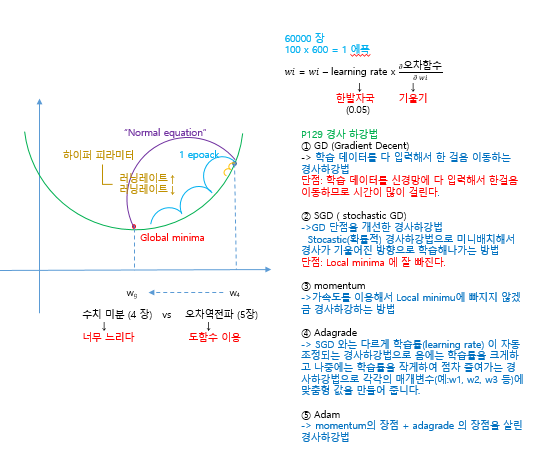

## ■ 경사 하강법을 코드로 구현

## 예제1. SGD 경사하강법을 코드로 구현하는 방법

In [ ]:
# 1. 맨위에 패키지 import 하는 코드
from common.optimizer import *

# 2. 학습하는 for문 바로 직전에 넣어주는 코드
optimizer = SGD()

# 3. for문 안에 학습하는 코드
grad = network.gradient(x_batch, t_batch)
parmas = network.parmas
optimizer.update(params,grad)

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, output_size=10)

# 하이퍼파라미터
epoch=17 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1) # 현재는 (60000/100) = 600

optimizer = SGD()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
    
    # 전에 했던 SGD 매개변수 갱신 부분을 지우고 위의 부분을 입력해준다.
    # 매개변수 갱신
    # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
    #     network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려
        print(loss)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 3)
plt.show()

## 예제2. momentum 경사하강법을 코드로 구현하시오~

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, output_size=10)

# 하이퍼파라미터
epoch=17 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Momentum()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
 
    # 매개변수 갱신
    # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
    #     network.params[key] -= learning_rate * grad[key]



    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 예제3. Adagrade 경사감소법 코드를 구현하시오!

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, output_size=10)

# 하이퍼파라미터
epoch=17 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Adagrade()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
 
    # 매개변수 갱신
    # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
    #     network.params[key] -= learning_rate * grad[key]



    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 예제4. Adam 옵티마이져를 이용하여 경사하강법을 구현하시오!

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, output_size=10)

# 하이퍼파라미터
epoch=17 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Adam()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
 
    # 매개변수 갱신
   # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
   #     network.params[key] -= learning_rate * grad[key]



    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## ■ 2. 가중치 초기값 선정 p.202

### " 랜덤으로 생성되는 가중치 W의 초기값을 어떻게 선정하느냐에 따라서 학습이 잘될수도 있고 잘 안될 수도 있다. "  

학습이 잘 되려면 가중치 __초기값들의 분포__가 __정규분포 형태__를 이루어야한다.   
그런데 np.random.randn이 가우시안 정규분포(평균이 0이고 표준편차 1)를 따르는 난수를 생성합니다.

### 1. 표준편차가 큰 경우

__" 시험문제가 너무 어려우면 아주 잘하는 학생들과 아주 못하는 학생들로 점수가 나뉜다. "__

__구현예 :__ 1 * np.random.randn(784, 50)

### 2. 표준편차가 작은 경우

__" 시험문제가 너무 쉬우면 학생들 점수가 평균에 가까워진다. "__ 

__구현예 :__ 0.01 * np.random.randn(784,50)

* 다른 표준편차를 지정하는 방법 2가지

1. Xavier(사비에르) 초기값 선정 --> sigmoid 함수와 짝꿍
2. He 초기값 선정 --> Relu 함수와 짝꿍

## 문제66.(오늘의 마지막문제)
## 현재 3층 신경망을 4층 신경망으로 구현하고 
## 옵티마이져를 Adam을 사용해서 20에폭의 정확도를 출력하는 코드를 작성하시오!


입력층 : 784    
은닉1층 : 50  
은닉2층 : 100  
은닉3층 : 100  
출력층 : 10  

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3'] = np.zeros(hidden_size3) 
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4'] = np.zeros(output_size)   

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, hidden_size3=100, output_size=10)

# 하이퍼파라미터
epoch=20 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Adam()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
 
    # 매개변수 갱신
   # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
   #     network.params[key] -= learning_rate * grad[key]



    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()